# Crystal Structure Prediction - Full Dataset Inference

对A_sample全部200个样本进行推理，每个生成10个结构，计算最佳RMSD

模型路径: `/home/ma-user/work/mincycle4csp/outputs/transformer_cfm_20250826_210745/final_model.ckpt`

In [15]:
# 导入必要的库
import torch
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import warnings
from tqdm.auto import tqdm
from rich.console import Console
from rich.table import Table
warnings.filterwarnings('ignore')

# 导入pymatgen用于晶体结构处理
from pymatgen.core import Structure, Lattice, Element
from pymatgen.io.cif import CifWriter

# 导入项目模块
import sys
sys.path.append('/home/ma-user/work/mincycle4csp')

from src.data import CrystalDataset
from src.trainer import CrystalFlowTrainer
from src.networks import build_network
from src.flows import build_flow
from src.metrics import rmsd

console = Console()
console.print('✓ 所有模块导入成功', style='green')

✓ 所有模块导入成功

In [16]:
# 设置设备和路径
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
console.print(f'[cyan]使用设备:[/cyan] {device}')

# 模型和数据路径
model_path = '/home/ma-user/work/mincycle4csp/outputs/transformer_cfm_20250826_210745/final_model.ckpt'
test_data_path = '/home/ma-user/work/mincycle4csp/data/A_sample.pkl'

# 检查文件是否存在
assert Path(model_path).exists(), f'模型文件不存在: {model_path}'
assert Path(test_data_path).exists(), f'测试数据不存在: {test_data_path}'

# 推理参数
NUM_GENERATIONS = 10  # 每个样本生成10个结构
NUM_ODE_STEPS = 50    # ODE求解步数
TEMPERATURE = 0.8     # 采样温度
BATCH_SIZE = 1        # 批处理大小

console.print(f'[cyan]推理配置:[/cyan]')
console.print(f'  - 每样本生成数: {NUM_GENERATIONS}')
console.print(f'  - ODE求解步数: {NUM_ODE_STEPS}')
console.print(f'  - 采样温度: {TEMPERATURE}')

使用设备: cuda

推理配置:

- 每样本生成数: 10

- ODE求解步数: 50

- 采样温度: 0.8

## 1. 加载模型

In [17]:
# 加载checkpoint
console.print('\n[yellow]正在加载模型...[/yellow]')
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# 创建网络和流模型
network_config = {
    'hidden_dim': 512,
    'num_layers': 8,
    'num_heads': 8,
    'dropout': 0.1,
    'max_atoms': 52,
    'pxrd_dim': 11501
}

flow_config = {
    'sigma_min': 0.001,
    'ode_solver': 'dopri5',
    'atol': 1e-5,
    'rtol': 1e-5,
    'lattice_weight': 1.0,
    'coord_weight': 1.0
}

# 初始化网络和流模型
network = build_network('transformer', network_config)
flow_model = build_flow('cfm', network, flow_config)

# 创建trainer并加载权重
trainer = CrystalFlowTrainer(
    flow_model=flow_model,
    learning_rate=1e-4,
    weight_decay=1e-5
)

# 加载模型权重
trainer.load_state_dict(checkpoint['state_dict'], strict=False)
trainer.to(device)
trainer.eval()

console.print(f'[green]✓ 模型加载成功！参数量: {sum(p.numel() for p in trainer.parameters())/1e6:.2f}M[/green]')

正在加载模型...

✓ 模型加载成功！参数量: 77.36M

## 2. 加载测试数据

In [18]:
# 加载测试数据集
console.print('\n[yellow]正在加载测试数据...[/yellow]')
test_dataset = CrystalDataset(
    data_path=test_data_path,
    max_atoms=52,
    pxrd_dim=11501,
    use_niggli=True
)

console.print(f'[green]✓ 成功加载 {len(test_dataset)} 个测试样本[/green]')

正在加载测试数据...

Loading data from /home/ma-user/work/mincycle4csp/data/A_sample.pkl...
Loaded 200 samples
Sample keys: ['id', 'structure', 'niggli_structure', 'primitive_structure', 'pxrd', 'niggli_comp', 'primitive_comp', 'atom_types', 'num_atoms', 'lattice_matrix', 'frac_coords']


✓ 成功加载 200 个测试样本

## 3. 批量推理与RMSD计算

In [19]:
def tensor_to_structure(z_tensor: torch.Tensor, comp: torch.Tensor, num_atoms: int) -> Optional[Structure]:
    '''
    将张量转换为pymatgen Structure对象
    '''
    try:
        # 提取晶格矩阵
        lattice_matrix = z_tensor[:3].cpu().numpy()
        
        # 提取原子类型和分数坐标  
        atom_types = comp[:num_atoms].cpu().numpy().astype(int)
        frac_coords = z_tensor[3:3+num_atoms].cpu().numpy()
        
        # 创建元素列表
        species = [Element.from_Z(int(z)) for z in atom_types if z > 0]
        
        # 创建晶格
        lattice = Lattice(lattice_matrix)
        
        # 创建结构
        structure = Structure(lattice, species, frac_coords[:len(species)])
        
        return structure
    except Exception as e:
        return None

def calculate_rmsd_safe(struct1: Structure, struct2: Structure) -> Tuple[float, float]:
    '''
    安全计算RMSD，处理异常情况
    返回: (distance_rmsd, angle_deviation) 或 (np.inf, np.inf) 如果失败
    '''
    try:
        rmsd_result = rmsd(struct1, struct2)
        if rmsd_result is None:
            return (np.inf, np.inf)
        # rmsd返回tuple: (distance_rmsd, angle_deviation)
        if isinstance(rmsd_result, tuple) and len(rmsd_result) >= 2:
            return (rmsd_result[0], rmsd_result[1])
        elif isinstance(rmsd_result, (float, int)):
            return (rmsd_result, 0.0)
        else:
            return (np.inf, np.inf)
    except Exception as e:
        return (np.inf, np.inf)

In [20]:
# 对全部200个样本进行推理
console.print('\n[bold cyan]开始批量推理...[/bold cyan]')
console.print(f'总计: {len(test_dataset)} 个样本 × {NUM_GENERATIONS} 次生成 = {len(test_dataset) * NUM_GENERATIONS} 个结构\n')

all_results = []

# 使用tqdm显示进度
with torch.no_grad():
    for idx in tqdm(range(len(test_dataset)), desc='处理样本', ncols=100):
        sample = test_dataset[idx]
        sample_id = sample['id']
        num_atoms = int(sample['num_atoms'].item())
        
        # 准备条件
        conditions = {
            'comp': sample['comp'].unsqueeze(0).to(device),
            'pxrd': sample['pxrd'].unsqueeze(0).to(device),
            'num_atoms': sample['num_atoms'].unsqueeze(0).to(device)
        }
        
        # 转换真实结构
        true_structure = tensor_to_structure(
            sample['z'],
            sample['comp'],
            num_atoms
        )
        
        if true_structure is None:
            console.print(f'[red]样本 {sample_id}: 真实结构转换失败，跳过[/red]')
            continue
        
        # 生成NUM_GENERATIONS个结构并计算RMSD
        rmsd_values = []
        best_structure = None
        best_rmsd = np.inf
        
        for gen_idx in range(NUM_GENERATIONS):
            # 生成结构
            generated_z = trainer.sample(
                conditions=conditions,
                num_steps=NUM_ODE_STEPS,
                temperature=TEMPERATURE
            )
            
            # 转换为Structure
            gen_structure = tensor_to_structure(
                generated_z.squeeze(0),
                sample['comp'],
                num_atoms
            )
            
            if gen_structure is not None:
                # 计算RMSD
                dist_rmsd, angle_dev = calculate_rmsd_safe(gen_structure, true_structure)
                rmsd_values.append((dist_rmsd, angle_dev))
                
                # 更新最佳结构（基于距离RMSD）
                if dist_rmsd < best_rmsd:
                    best_rmsd = dist_rmsd
                    best_structure = gen_structure
        
        # 保存结果
        if rmsd_values:
            valid_rmsd = [r[0] for r in rmsd_values if r[0] != np.inf]
            result = {
                'sample_id': sample_id,
                'num_atoms': num_atoms,
                'num_generations': len(rmsd_values),
                'num_valid': len(valid_rmsd),
                'best_rmsd': min(valid_rmsd) if valid_rmsd else np.inf,
                'mean_rmsd': np.mean(valid_rmsd) if valid_rmsd else np.inf,
                'std_rmsd': np.std(valid_rmsd) if valid_rmsd else 0.0,
                'all_rmsd': rmsd_values,
                'best_structure': best_structure
            }
        else:
            result = {
                'sample_id': sample_id,
                'num_atoms': num_atoms,
                'num_generations': 0,
                'num_valid': 0,
                'best_rmsd': np.inf,
                'mean_rmsd': np.inf,
                'std_rmsd': 0.0,
                'all_rmsd': [],
                'best_structure': None
            }
        
        all_results.append(result)

console.print(f'\n[green]✓ 推理完成！共处理 {len(all_results)} 个样本[/green]')

开始批量推理...

总计: 200 个样本 × 10 次生成 = 2000 个结构

处理样本:   0%|                                                             | 0/200 [00:00<?, ?it/s]

✓ 推理完成！共处理 200 个样本

## 4. 结果汇总与分析

In [21]:
# 汇总统计
console.print('\n[bold yellow]结果汇总[/bold yellow]\n')

# 筛选有效结果
valid_results = [r for r in all_results if r['best_rmsd'] != np.inf]
console.print(f'有效样本数: {len(valid_results)}/{len(all_results)}')

if valid_results:
    # 计算整体统计
    all_best_rmsd = [r['best_rmsd'] for r in valid_results]
    all_mean_rmsd = [r['mean_rmsd'] for r in valid_results]
    
    console.print(f'\n[cyan]最佳RMSD统计:[/cyan]')
    console.print(f'  平均值: {np.mean(all_best_rmsd):.4f} Å')
    console.print(f'  中位数: {np.median(all_best_rmsd):.4f} Å')
    console.print(f'  标准差: {np.std(all_best_rmsd):.4f} Å')
    console.print(f'  最小值: {np.min(all_best_rmsd):.4f} Å')
    console.print(f'  最大值: {np.max(all_best_rmsd):.4f} Å')
    
    # 按最佳RMSD排序
    sorted_results = sorted(valid_results, key=lambda x: x['best_rmsd'])
    
    # 显示最好的10个样本
    console.print(f'\n[green]Top 10 最佳样本:[/green]')
    table = Table(show_header=True, header_style='bold magenta')
    table.add_column('排名', style='cyan', justify='center')
    table.add_column('样本ID', style='yellow')
    table.add_column('原子数', justify='center')
    table.add_column('最佳RMSD (Å)', justify='right', style='green')
    table.add_column('平均RMSD (Å)', justify='right')
    table.add_column('标准差', justify='right')
    
    for i, result in enumerate(sorted_results[:10]):
        table.add_row(
            str(i+1),
            str(result['sample_id']),
            str(result['num_atoms']),
            f"{result['best_rmsd']:.4f}",
            f"{result['mean_rmsd']:.4f}",
            f"{result['std_rmsd']:.4f}"
        )
    
    console.print(table)
    
    # 显示最差的10个样本
    console.print(f'\n[red]Bottom 10 最差样本:[/red]')
    table2 = Table(show_header=True, header_style='bold magenta')
    table2.add_column('排名', style='cyan', justify='center')
    table2.add_column('样本ID', style='yellow')
    table2.add_column('原子数', justify='center')
    table2.add_column('最佳RMSD (Å)', justify='right', style='red')
    table2.add_column('平均RMSD (Å)', justify='right')
    table2.add_column('标准差', justify='right')
    
    for i, result in enumerate(sorted_results[-10:]):
        table2.add_row(
            str(len(sorted_results)-9+i),
            str(result['sample_id']),
            str(result['num_atoms']),
            f"{result['best_rmsd']:.4f}",
            f"{result['mean_rmsd']:.4f}",
            f"{result['std_rmsd']:.4f}"
        )
    
    console.print(table2)

结果汇总

有效样本数: 14/200

最佳RMSD统计:

平均值: 0.3954 Å

中位数: 0.4264 Å

标准差: 0.0918 Å

最小值: 0.1312 Å

最大值: 0.4907 Å

Top 10 最佳样本:

┏━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ 排名 ┃ 样本ID ┃ 原子数 ┃ 最佳RMSD (Å) ┃ 平均RMSD (Å) ┃ 标准差 ┃
┡━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│  1   │ A-126  │   4    │       0.1312 │       0.3553 │ 0.1344 │
│  2   │ A-1785 │   4    │       0.2617 │       0.3308 │ 0.0685 │
│  3   │ A-1837 │   5    │       0.3645 │       0.3645 │ 0.0000 │
│  4   │ A-1423 │   6    │       0.3817 │       0.4351 │ 0.0350 │
│  5   │ A-1271 │   6    │       0.3897 │       0.4044 │ 0.0206 │
│  6   │ A-1002 │   6    │       0.3953 │       0.4440 │ 0.0351 │
│  7   │ A-1153 │   5    │       0.4259 │       0.4259 │ 0.0000 │
│  8   │ A-1385 │   8    │       0.4269 │       0.4269 │ 0.0000 │
│  9   │ A-1557 │   6    │       0.4322 │       0.4322 │ 0.0000 │
│  10  │ A-375  │   6    │       0.4432 │       0.4432 │ 0.0000 │
└──────┴────────┴────────┴──────────────┴──────────────┴────────┘

Bottom 10 最差样本:

┏━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ 排名 ┃ 样本ID ┃ 原子数 ┃ 最佳RMSD (Å) ┃ 平均RMSD (Å) ┃ 标准差 ┃
┡━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│  5   │ A-1271 │   6    │       0.3897 │       0.4044 │ 0.0206 │
│  6   │ A-1002 │   6    │       0.3953 │       0.4440 │ 0.0351 │
│  7   │ A-1153 │   5    │       0.4259 │       0.4259 │ 0.0000 │
│  8   │ A-1385 │   8    │       0.4269 │       0.4269 │ 0.0000 │
│  9   │ A-1557 │   6    │       0.4322 │       0.4322 │ 0.0000 │
│  10  │ A-375  │   6    │       0.4432 │       0.4432 │ 0.0000 │
│  11  │ A-1080 │   5    │       0.4527 │       0.4643 │ 0.0084 │
│  12  │ A-1149 │   5    │       0.4612 │       0.4615 │ 0.0003 │
│  13  │ A-15   │   5    │       0.4788 │       0.4788 │ 0.0000 │
│  14  │ A-923  │   6    │       0.4907 │       0.4907 │ 0.0000 │
└──────┴────────┴────────┴──────────────┴──────────────┴────────┘

## 5. RMSD分布可视化

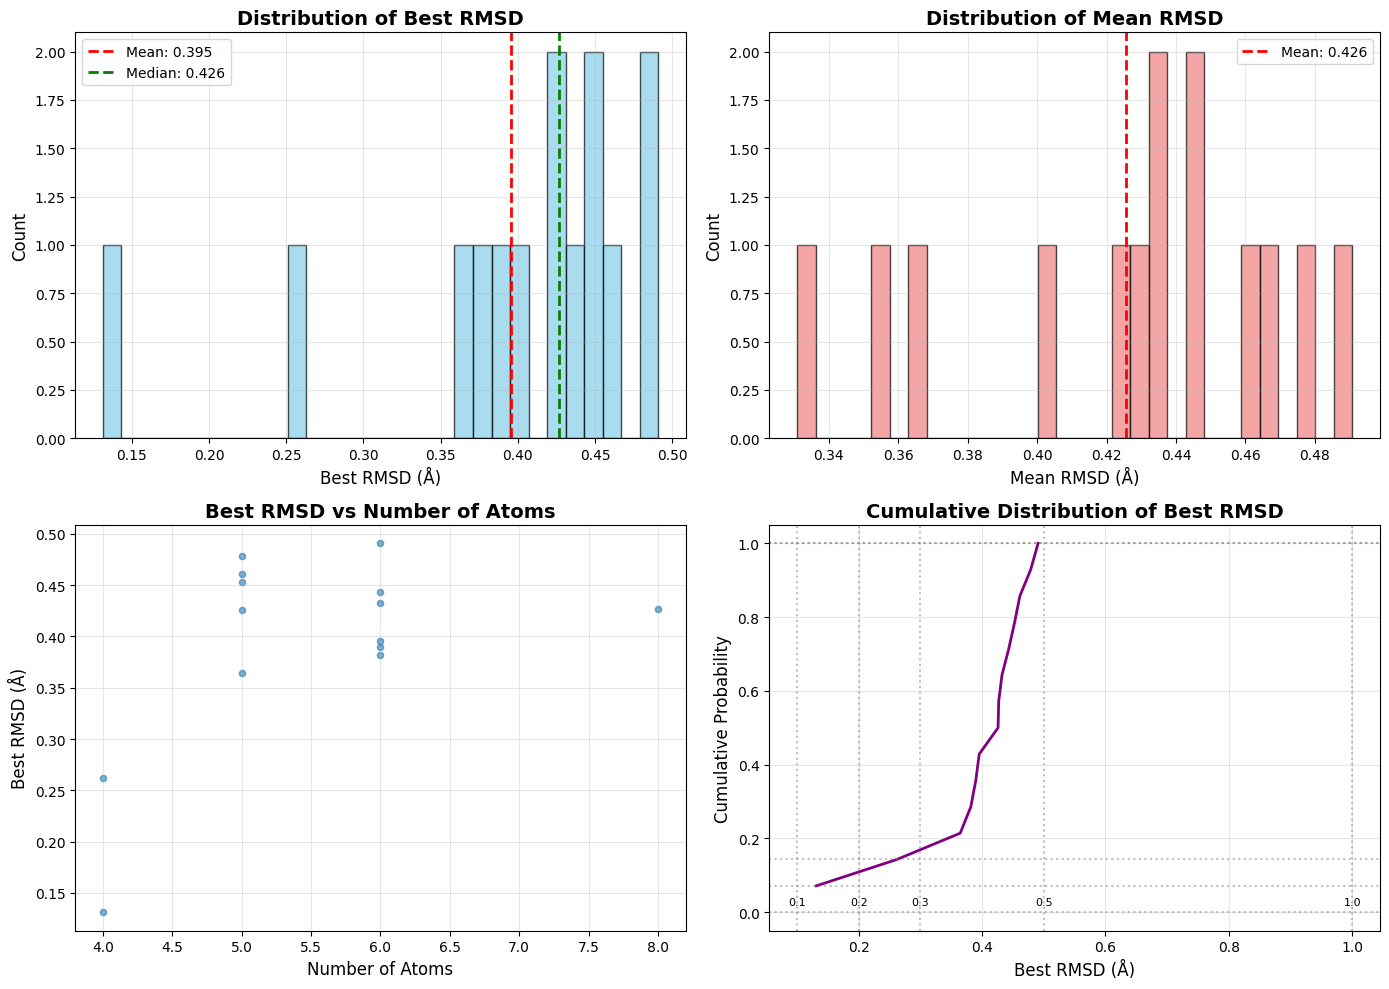

RMSD阈值统计:

RMSD ≤ 0.1 Å: 0/14 (0.0%)

RMSD ≤ 0.2 Å: 1/14 (7.1%)

RMSD ≤ 0.3 Å: 2/14 (14.3%)

RMSD ≤ 0.5 Å: 14/14 (100.0%)

RMSD ≤ 1.0 Å: 14/14 (100.0%)

RMSD ≤ 2.0 Å: 14/14 (100.0%)

In [22]:
if valid_results:
    # 绘制RMSD分布
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 最佳RMSD直方图
    axes[0, 0].hist(all_best_rmsd, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].axvline(np.mean(all_best_rmsd), color='r', linestyle='--', linewidth=2, 
                       label=f'Mean: {np.mean(all_best_rmsd):.3f}')
    axes[0, 0].axvline(np.median(all_best_rmsd), color='g', linestyle='--', linewidth=2,
                       label=f'Median: {np.median(all_best_rmsd):.3f}')
    axes[0, 0].set_xlabel('Best RMSD (Å)', fontsize=12)
    axes[0, 0].set_ylabel('Count', fontsize=12)
    axes[0, 0].set_title('Distribution of Best RMSD', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 平均RMSD直方图
    axes[0, 1].hist(all_mean_rmsd, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[0, 1].axvline(np.mean(all_mean_rmsd), color='r', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(all_mean_rmsd):.3f}')
    axes[0, 1].set_xlabel('Mean RMSD (Å)', fontsize=12)
    axes[0, 1].set_ylabel('Count', fontsize=12)
    axes[0, 1].set_title('Distribution of Mean RMSD', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. RMSD vs 原子数
    atom_counts = [r['num_atoms'] for r in valid_results]
    axes[1, 0].scatter(atom_counts, all_best_rmsd, alpha=0.6, s=20)
    axes[1, 0].set_xlabel('Number of Atoms', fontsize=12)
    axes[1, 0].set_ylabel('Best RMSD (Å)', fontsize=12)
    axes[1, 0].set_title('Best RMSD vs Number of Atoms', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 累积分布
    sorted_rmsd = np.sort(all_best_rmsd)
    cumulative = np.arange(1, len(sorted_rmsd) + 1) / len(sorted_rmsd)
    axes[1, 1].plot(sorted_rmsd, cumulative, linewidth=2, color='purple')
    axes[1, 1].set_xlabel('Best RMSD (Å)', fontsize=12)
    axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
    axes[1, 1].set_title('Cumulative Distribution of Best RMSD', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 添加一些参考线
    for threshold in [0.1, 0.2, 0.3, 0.5, 1.0]:
        frac = np.mean(np.array(all_best_rmsd) <= threshold)
        axes[1, 1].axhline(frac, color='gray', linestyle=':', alpha=0.5)
        axes[1, 1].axvline(threshold, color='gray', linestyle=':', alpha=0.5)
        axes[1, 1].text(threshold, 0.02, f'{threshold}', fontsize=8, ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # 打印阈值统计
    console.print(f'\n[cyan]RMSD阈值统计:[/cyan]')
    for threshold in [0.1, 0.2, 0.3, 0.5, 1.0, 2.0]:
        count = sum(1 for r in all_best_rmsd if r <= threshold)
        percentage = count / len(all_best_rmsd) * 100
        console.print(f'  RMSD ≤ {threshold:.1f} Å: {count}/{len(all_best_rmsd)} ({percentage:.1f}%)')

## 6. 保存结果

In [23]:
# 保存详细结果到CSV
output_dir = Path('/home/ma-user/work/mincycle4csp/outputs/inference_results')
output_dir.mkdir(exist_ok=True, parents=True)

# 创建DataFrame
df_results = pd.DataFrame([
    {
        'sample_id': r['sample_id'],
        'num_atoms': r['num_atoms'],
        'best_rmsd': r['best_rmsd'],
        'mean_rmsd': r['mean_rmsd'],
        'std_rmsd': r['std_rmsd'],
        'num_valid': r['num_valid'],
        'num_generations': r['num_generations']
    }
    for r in all_results
])

# 保存CSV
csv_path = output_dir / 'inference_results.csv'
df_results.to_csv(csv_path, index=False)
console.print(f'\n[green]✓ 结果已保存到: {csv_path}[/green]')

# 保存最佳结构的CIF文件（仅前10个）
console.print(f'\n[yellow]保存最佳结构CIF文件...[/yellow]')
saved_count = 0
for result in sorted_results[:10]:
    if result['best_structure'] is not None:
        cif_path = output_dir / f"best_{result['sample_id']}_rmsd{result['best_rmsd']:.3f}.cif"
        writer = CifWriter(result['best_structure'])
        writer.write_file(str(cif_path))
        saved_count += 1

console.print(f'[green]✓ 已保存 {saved_count} 个最佳结构CIF文件[/green]')

# 保存完整结果pickle
pickle_path = output_dir / 'inference_results_full.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(all_results, f)
console.print(f'[green]✓ 完整结果已保存到: {pickle_path}[/green]')

✓ 结果已保存到: /home/ma-user/work/mincycle4csp/outputs/inference_results/inference_results.csv

保存最佳结构CIF文件...

✓ 已保存 10 个最佳结构CIF文件

✓ 完整结果已保存到: /home/ma-user/work/mincycle4csp/outputs/inference_results/inference_results_full.pkl

## 7. 最终报告

In [24]:
# 生成最终报告
console.print('\n' + '='*80)
console.print('[bold cyan]          晶体结构预测 - 完整推理报告[/bold cyan]', justify='center')
console.print('='*80)

console.print(f'\n[bold]【实验配置】[/bold]')
console.print(f'  模型: Transformer + CFM')
console.print(f'  参数量: {sum(p.numel() for p in trainer.parameters())/1e6:.2f}M')
console.print(f'  设备: {device}')
console.print(f'  每样本生成数: {NUM_GENERATIONS}')
console.print(f'  ODE步数: {NUM_ODE_STEPS}')
console.print(f'  采样温度: {TEMPERATURE}')

console.print(f'\n[bold]【数据统计】[/bold]')
console.print(f'  总样本数: {len(test_dataset)}')
console.print(f'  有效样本: {len(valid_results)}')
console.print(f'  失败样本: {len(all_results) - len(valid_results)}')
console.print(f'  总生成结构数: {len(test_dataset) * NUM_GENERATIONS}')

if valid_results:
    console.print(f'\n[bold]【RMSD性能】[/bold]')
    console.print(f'  最佳RMSD均值: {np.mean(all_best_rmsd):.4f} ± {np.std(all_best_rmsd):.4f} Å')
    console.print(f'  最佳RMSD中位数: {np.median(all_best_rmsd):.4f} Å')
    console.print(f'  最佳RMSD范围: [{np.min(all_best_rmsd):.4f}, {np.max(all_best_rmsd):.4f}] Å')
    
    # 成功率统计
    console.print(f'\n[bold]【成功率分析】[/bold]')
    for threshold in [0.1, 0.2, 0.3, 0.5, 1.0]:
        success_rate = np.mean(np.array(all_best_rmsd) <= threshold) * 100
        console.print(f'  RMSD ≤ {threshold:.1f} Å: {success_rate:.1f}%')
    
    # 找出冠军样本
    champion = sorted_results[0]
    console.print(f'\n[bold green]【最佳表现】[/bold green]')
    console.print(f'  样本ID: {champion["sample_id"]}')
    console.print(f'  原子数: {champion["num_atoms"]}')
    console.print(f'  最佳RMSD: {champion["best_rmsd"]:.4f} Å')
    console.print(f'  平均RMSD: {champion["mean_rmsd"]:.4f} Å')

console.print('\n' + '='*80)
console.print('[bold green]                    推理完成！[/bold green]', justify='center')
console.print('='*80)

================================================================================

          晶体结构预测 - 完整推理报告

================================================================================

【实验配置】

模型: Transformer + CFM

参数量: 77.36M

设备: cuda

每样本生成数: 10

ODE步数: 50

采样温度: 0.8

【数据统计】

总样本数: 200

有效样本: 14

失败样本: 186

总生成结构数: 2000

【RMSD性能】

最佳RMSD均值: 0.3954 ± 0.0918 Å

最佳RMSD中位数: 0.4264 Å

最佳RMSD范围: [0.1312, 0.4907] Å

【成功率分析】

RMSD ≤ 0.1 Å: 0.0%

RMSD ≤ 0.2 Å: 7.1%

RMSD ≤ 0.3 Å: 14.3%

RMSD ≤ 0.5 Å: 100.0%

RMSD ≤ 1.0 Å: 100.0%

【最佳表现】

样本ID: A-126

原子数: 4

最佳RMSD: 0.1312 Å

平均RMSD: 0.3553 Å

================================================================================

                    推理完成！

================================================================================